In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload

In [4]:
from TargetDistributions.DoubleWell import ManyWellEnergy
from FittedModels.utils.plotting_utils import plot_samples_vs_contours_many_well

In [5]:
from FittedModels.Models.FlowModel import FlowModel
from AIS_train.train_AIS import AIS_trainer
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils.plotting_utils import plot_history, plot_distributions, plot_samples

import matplotlib.pyplot as plt
import torch
from Utils.plotting_utils import plot_func2D, plot_distribution
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
torch.set_default_dtype(torch.float64)

def plotter(*args, **kwargs):
    # wrap plotting function like this so it displays during training
    plot_samples_vs_contours_many_well(*args, **kwargs)
    plt.show()

In [6]:
dim = 8
target = ManyWellEnergy(dim=dim, a=-0.5, b=-6)

In [7]:
n_samples_expectation = int(1e4)
n_samples=int(1e4)

# Vanilla IS

In [8]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
vanilla_IS = VanillaImportanceSampling(sampling_distribution=learnt_sampler, target_distribution=target)
with torch.no_grad():
    expectation_vanilla, info_dict_vanilla = \
    vanilla_IS.calculate_expectation(n_samples_expectation, expectation_function=expectation_function)
    print(f"ESS is {info_dict_vanilla['effective_sample_size']/n_samples_expectation}, \
          var is {torch.var(info_dict_vanilla['normalised_sampling_weights'])}")

ESS is 0.0006762140535903054,           var is 1.477969472850836e-05


# DReG likelihood

In [25]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
tester = AIS_trainer(target, learnt_sampler, loss_type=False, n_distributions=5, n_steps_transition_operator=5,
                    step_size=1.0, transition_operator="Metropolis", learnt_dist_kwargs={"lr": 5e-4},
                     loss_type_2="alpha_2")

TypeError: super(type, obj): obj must be an instance or subtype of type

In [26]:
expectation_before, info_dict_before = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict_before['effective_sample_size'].item() / n_samples_expectation)

0.012417445259079157


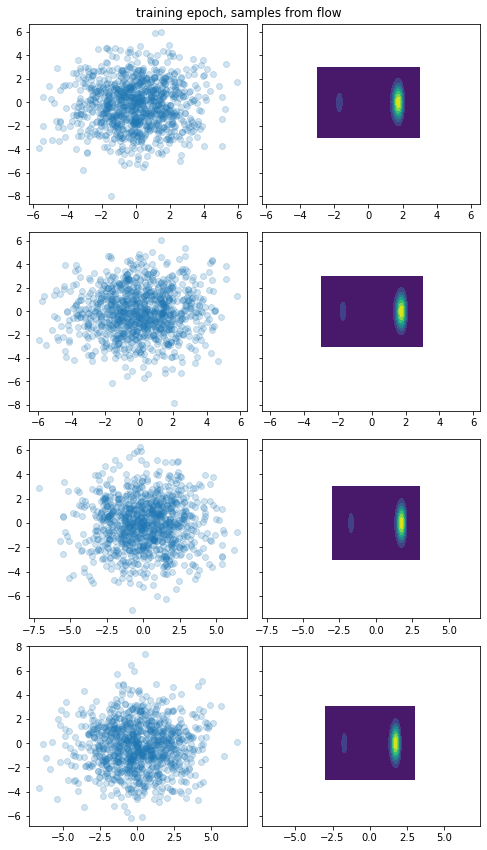

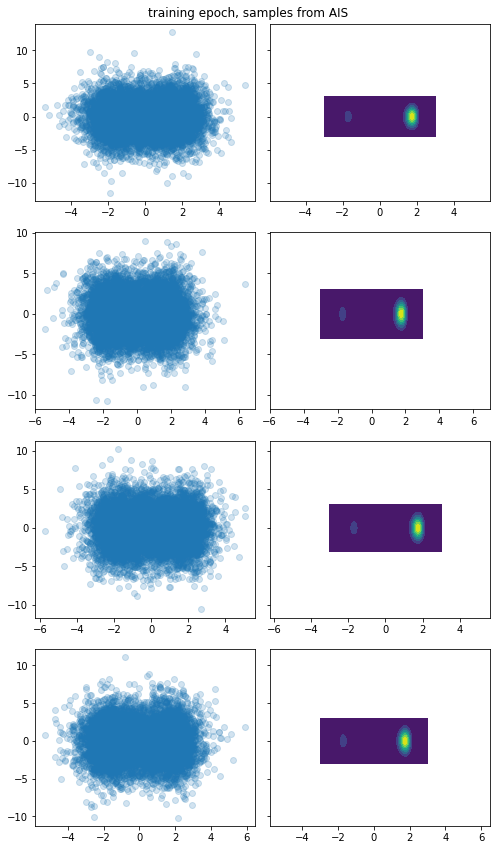

In [19]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict_before["samples"])

  0%|                                                                                                                                                          | 0/300 [00:00<?, ?it/s]

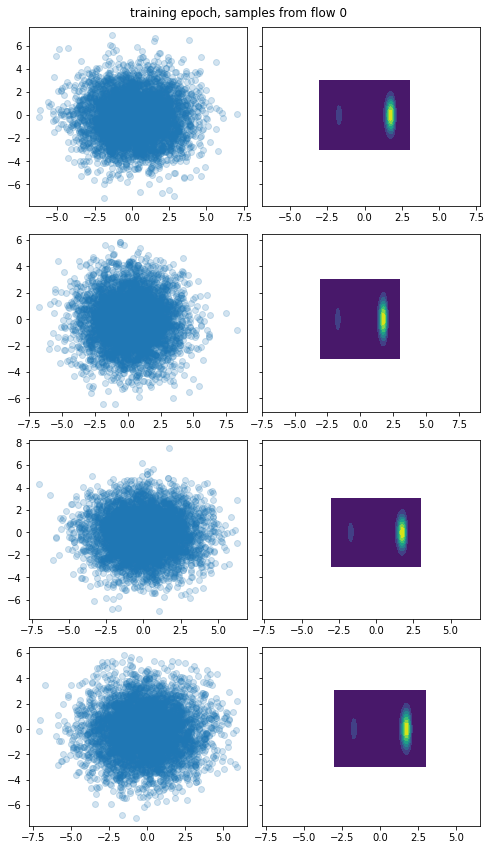

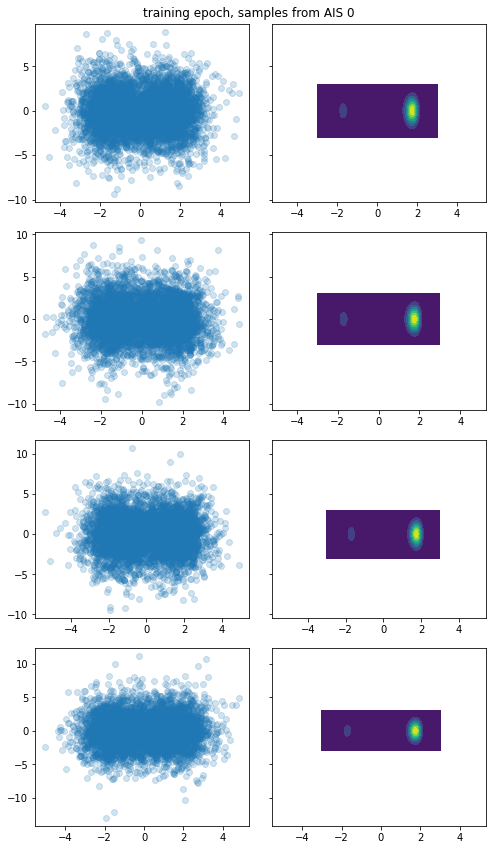

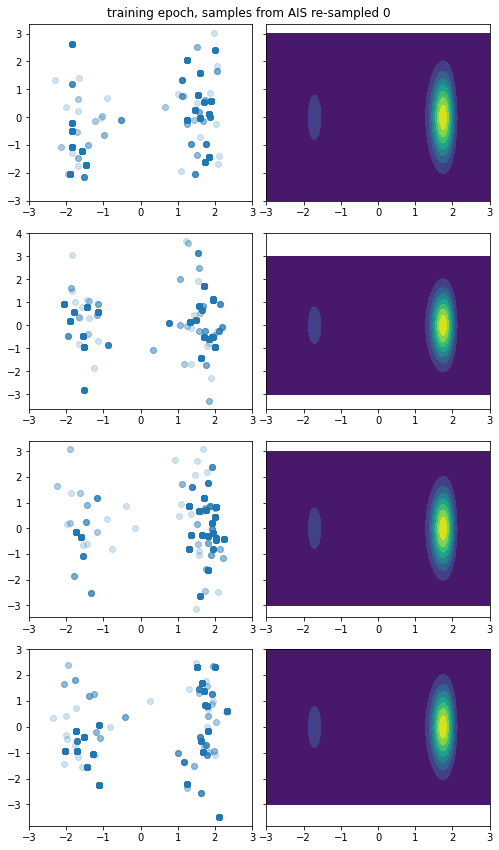

loss: 47.346025623553864,   log_p_x_post_AIS 11.602830521015518, ESS 0.002469851576492379:  20%|██████████▊                                           | 60/300 [12:58<49:33, 12.39s/it]

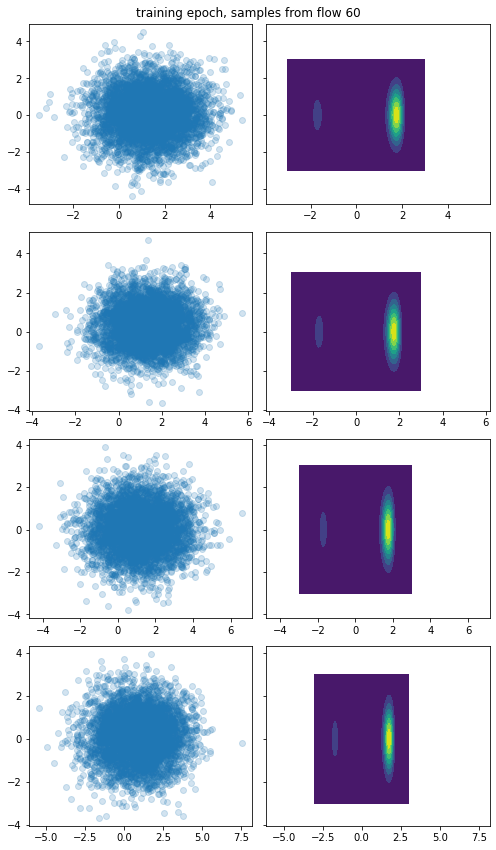

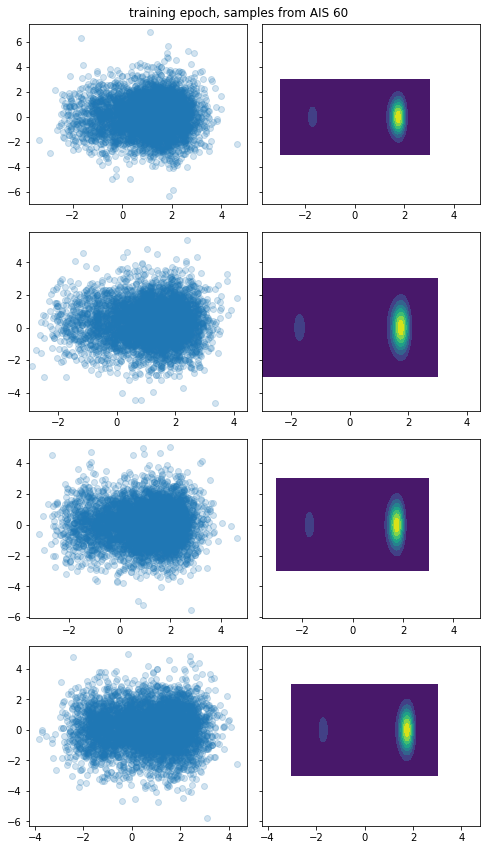

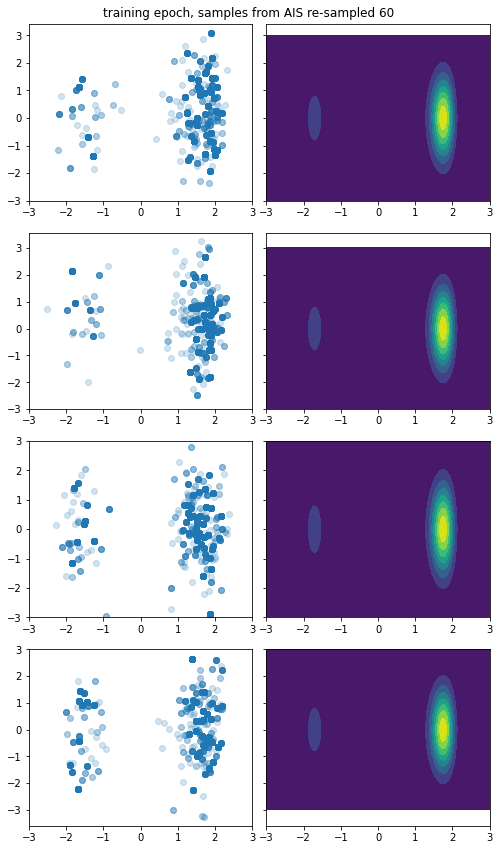

loss: 47.491000238086436,   log_p_x_post_AIS 14.495591206124345, ESS 0.003254617830590089:  40%|█████████████████████▏                               | 120/300 [27:26<44:19, 14.77s/it]

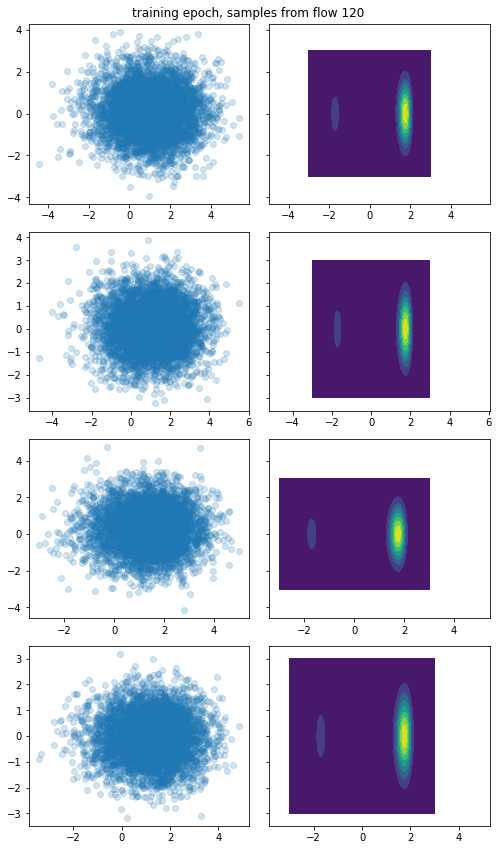

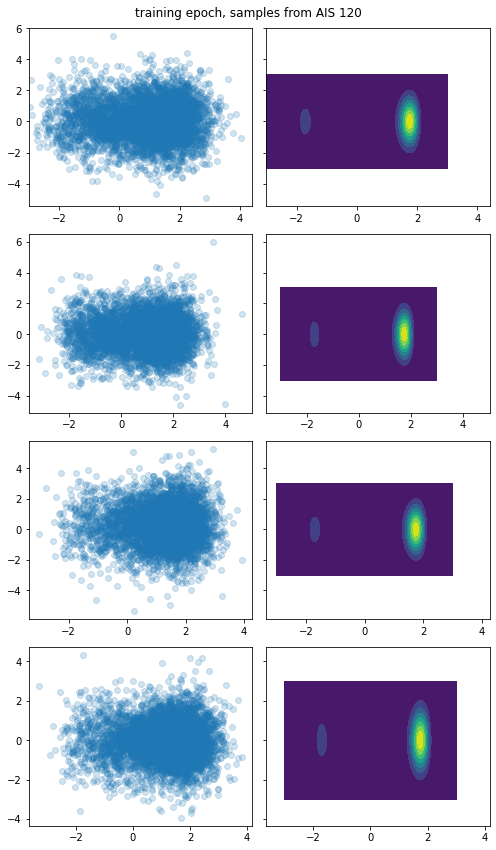

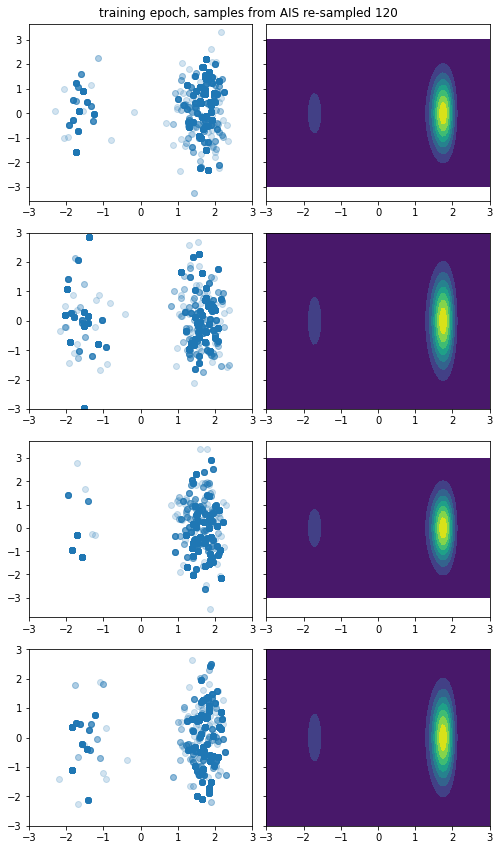

loss: 46.82078093638935,   log_p_x_post_AIS 16.382935663935232, ESS 0.005516687628425853:  60%|████████████████████████████████▍                     | 180/300 [41:22<26:53, 13.44s/it]

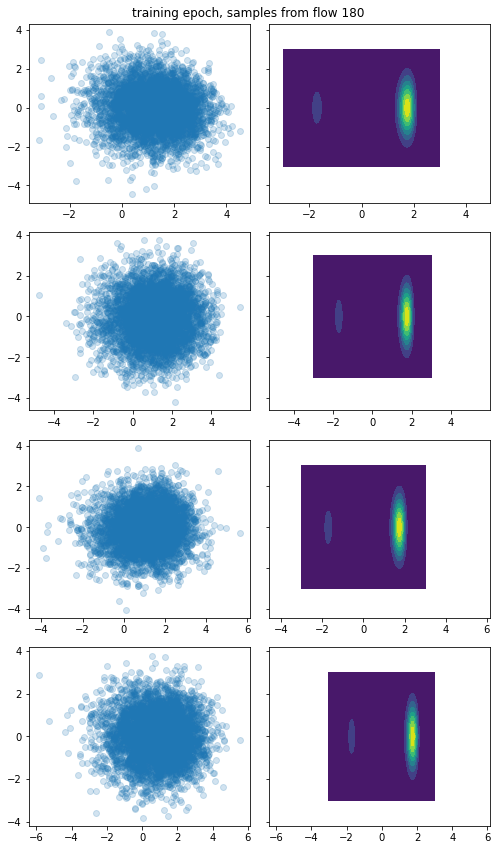

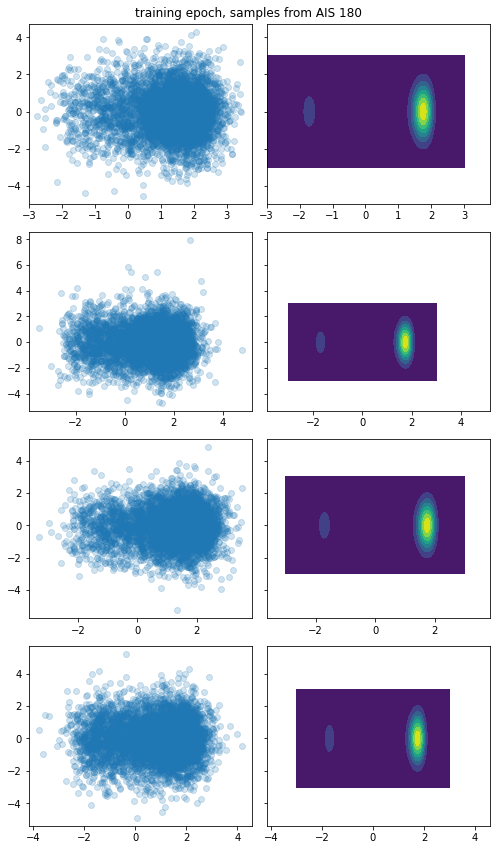

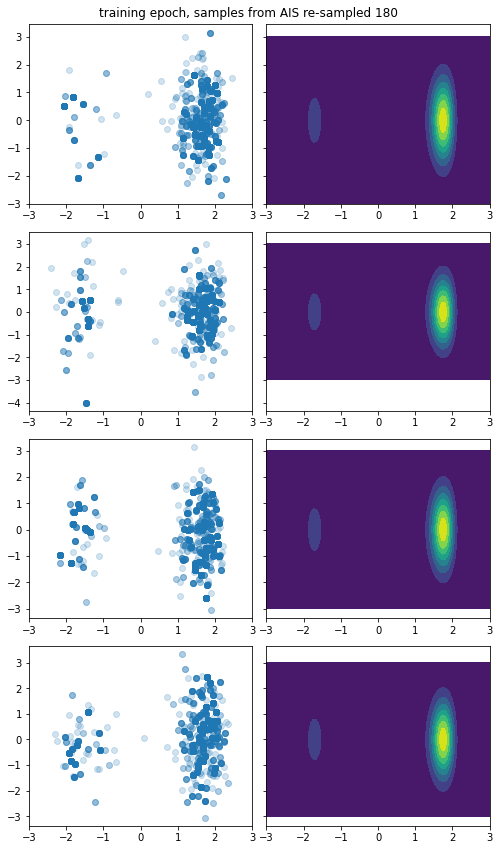

loss: 46.571821617787464,   log_p_x_post_AIS 17.834031909622418, ESS 0.009736142011976614:  80%|██████████████████████████████████████████▍          | 240/300 [55:29<14:39, 14.66s/it]

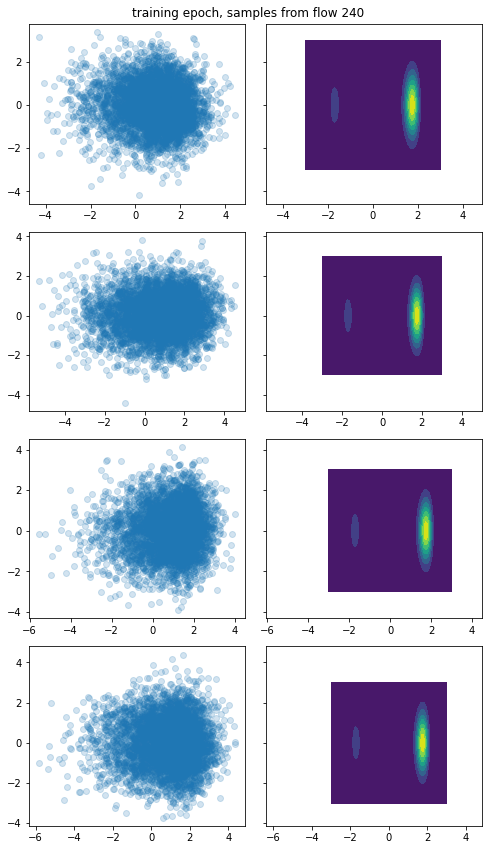

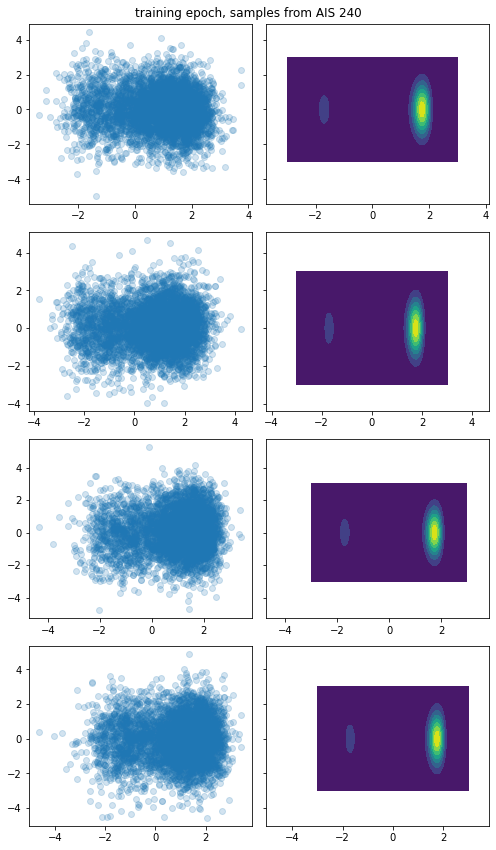

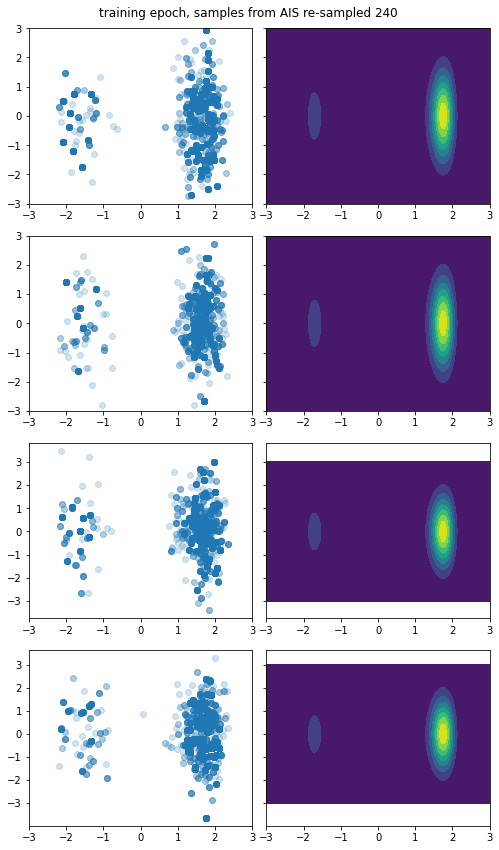

loss: 45.48832921198788,   log_p_x_post_AIS 16.078500545321006, ESS 0.01741876204518489: 100%|█████████████████████████████████████████████████████| 300/300 [1:09:16<00:00, 13.86s/it]


In [20]:
history = tester.train(300, batch_size=int(5e3), intermediate_plots=True, n_plots=5, plotting_func=plotter)

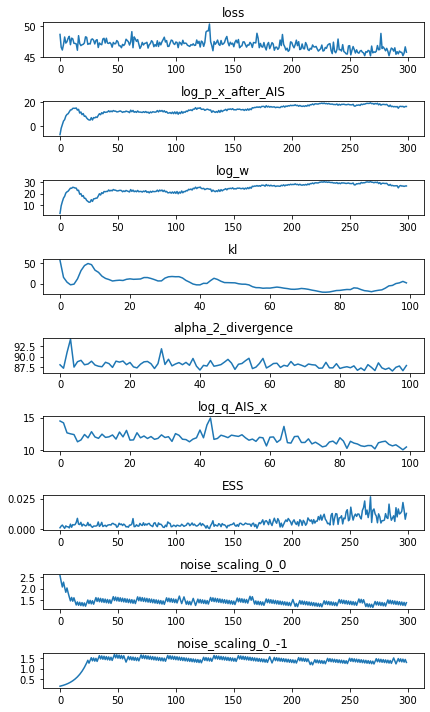

In [21]:
plot_history(history)

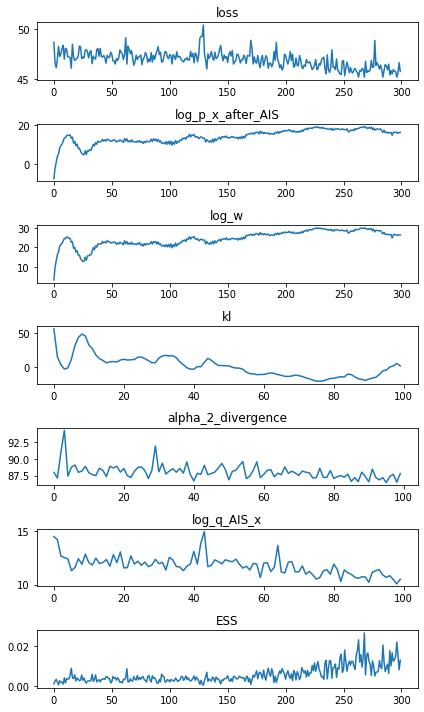

In [22]:
plot_history(dict([(key, history[key]) for key in ('loss', 'log_p_x_after_AIS', 'log_w', 'kl', 
                                               'alpha_2_divergence', 'log_q_AIS_x', 'ESS')]))

In [23]:
expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict['effective_sample_size'].item() / n_samples_expectation)

0.011098421891059643


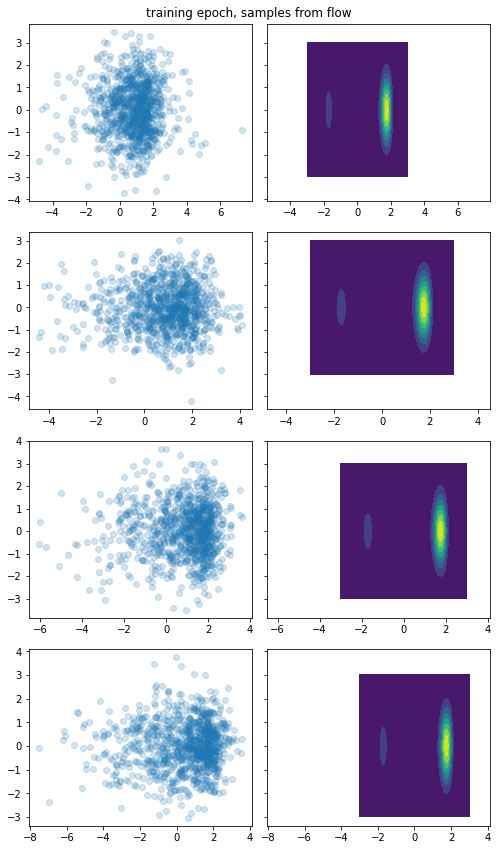

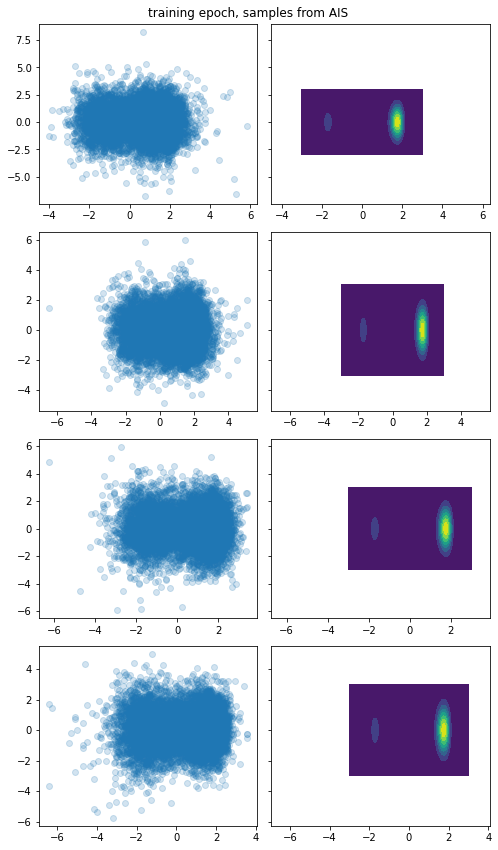

In [24]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict["samples"])